# Data Wrangling
<p> The first step of the process before building our model is data wrangling. The Airbnb datasets provided need to be cleaned and edited for optimal model usage. This includes performing initial feature selection, imputing missing data, examining collinearity, performing variable transformations, and further pre-processing.</p>

### Import Libraries

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

### Data Exploration and Analysis
<p> We begin by examining the listings dataset below. This is the primary dataset for Airbnb listings in New York City - it contains a number of categorical and quantitative features. Through exploration and analysis we will determine which ones will be useful to our model.</p>

In [34]:
# Read in the data 
listings = pd.read_csv('datasets/listings.csv', delimiter=',')
calendar = pd.read_csv('datasets/calendar.csv', delimiter=',', usecols=range(4))

# View feature list
print listings.columns.values

['id' 'scrape_id' 'last_scraped' 'name' 'picture_url' 'host_id' 'host_name'
 'host_since' 'host_picture_url' 'street' 'neighbourhood'
 'neighbourhood_cleansed' 'city' 'state' 'zipcode' 'market' 'country'
 'latitude' 'longitude' 'is_location_exact' 'property_type' 'room_type'
 'accommodates' 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'square_feet'
 'price' 'weekly_price' 'monthly_price' 'guests_included' 'extra_people'
 'minimum_nights' 'maximum_nights' 'calendar_updated' 'availability_30'
 'availability_60' 'availability_90' 'availability_365'
 'calendar_last_scraped' 'number_of_reviews' 'first_review' 'last_review'
 'review_scores_rating' 'review_scores_accuracy'
 'review_scores_cleanliness' 'review_scores_checkin'
 'review_scores_communication' 'review_scores_location'
 'review_scores_value' 'host_listing_count']


In [35]:
# Unsuppress Output
pd.options.display.max_columns = 5

# Split into predictor and response
y = listings[['price']]

# Append price at the end of the listings table
del listings['price']
listings = listings.join(y)

# Show listings dataframe
print 'Predictor Data Shape: ', listings.shape
listings.head(n = 3)

Predictor Data Shape:  (27392, 52)


,id,scrape_id,...,host_listing_count,price
0,1069266,2.015010e+13,...,1,$160.00
1,1846722,2.015010e+13,...,2,$105.00
2,2061725,2.015010e+13,...,4,$58.00


#### Price Distribution of Listings and Clustering
<p>The core listings dataset is comprised of 27,392 entries of Airbnb listing data with 51 total features including `bedrooms`, `bathrooms`, `room_type`, `review_score`, and more. We first examine the listings by price to get an initial impression of distribution.</p>

In [36]:
# plot_hist
# Function to plot histograms
#
# Input: n (integer for subplots)
#        titles (list of titles)
#        ranges (list of values)
# Output: None
def plot_hist(n, titles, ranges):
    fig, ax = plt.subplots(n, figsize=(8, 7.5))
    for i in range(n):
        d, bins, patches = ax[i].hist(ranges[i], 60, normed=1, color='#E35A5C', alpha=0.75)
        ax[i].set_title(titles[i])
        ax[i].set_xlabel("Value")
        ax[i].set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

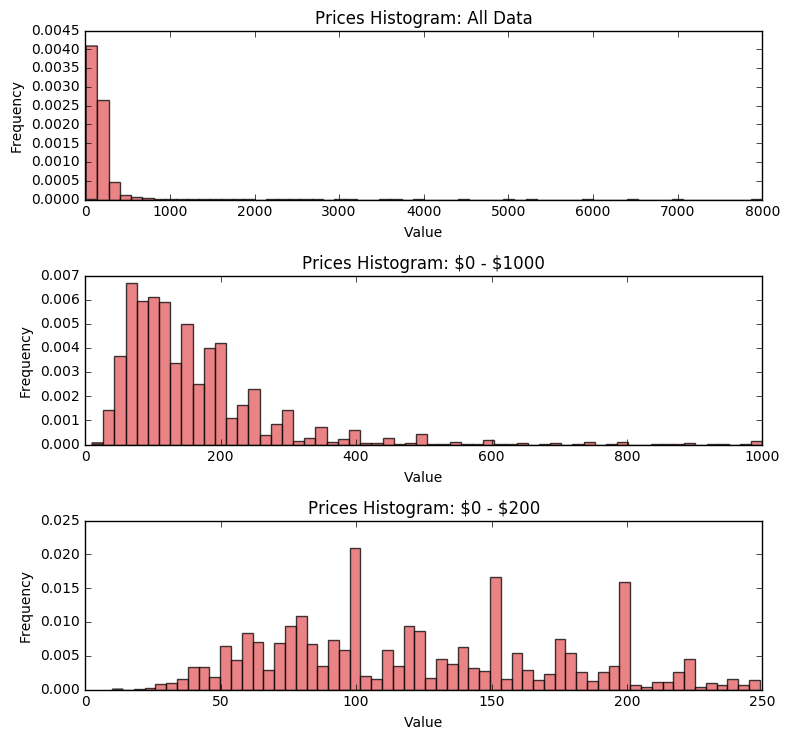

In [43]:
# Visualize price table, changing them to floats and replacing the commas with a blank
prices = listings['price'].apply(lambda s: float(s[1:].replace(',','')))

# Plot histograms of price distribution
plot_hist(3, ['Prices Histogram: All Data', 'Prices Histogram: \$0 - \$1000', 
               'Prices Histogram: \$0 - \$200'], [prices, prices[prices <= 1000], prices[prices < 250]])

<p>For our baseline model, we can start by removing features that we intuitively sense will not impact a listing's price. This includes 11 features:</p>

* `scrape_id`: Irrelevant to actual property data.
* `last_scraped`: All within first three days of January, irrelevant to actual property data.
* `picture_url`: Irrelevant to actual property data. 
* `host_picture_url`: Irrelevant to actual property data.
* `neighbourhood`: The `neighbourhood_cleansed` feature presents the same data in a better format.
* `state`: All listings are in the state of NY - this is useless.
* `market`: All listings are in the NY market - this is useless.
* `country`: All listings are in the USA - this is useless.
* `weekly_price`: Function of daily price - should not be a predictor.
* `monthly_price`: Function of daily price - should not be a predictor.
* `calendar_last_scraped`: All within first three days of January, irrelevant to actual property data.

In [38]:
# Features to drop
bad_features = ['scrape_id', 'last_scraped', 'picture_url', 'host_picture_url', 'neighbourhood', 'state', 
                'market', 'country', 'weekly_price', 'monthly_price', 'calendar_last_scraped']

listings.drop(bad_features, axis=1, inplace=True)
 
print 'Predictor Data Shape: ', listings.shape

Predictor Data Shape:  (27392, 41)


### Data Clustering

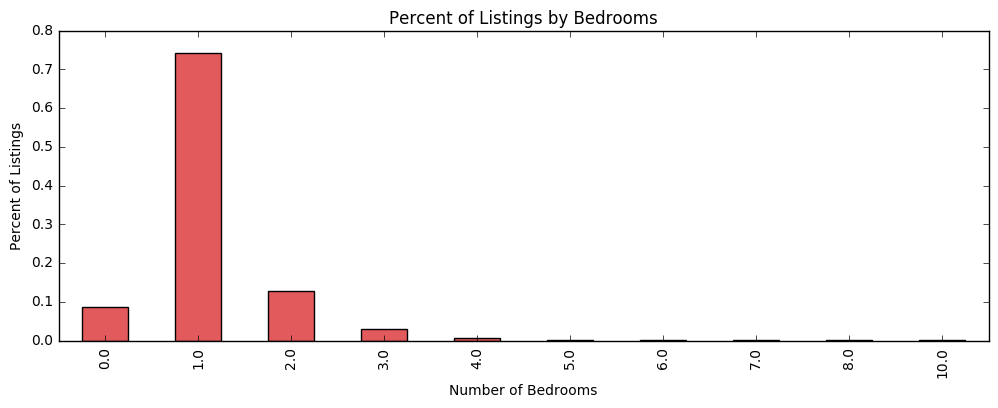

In [40]:
# Get frequency of bedroom number for listings
bedrooms_counts = Counter(listings.bedrooms)
tdf = pd.DataFrame.from_dict(bedrooms_counts, orient='index').sort_values(by=0)
tdf = (tdf.iloc[-10:, :] / 27392)

# Sort bedroom dataframe by number
tdf.sort_index(axis=0, ascending=True, inplace=True)

# Plot percent of listings by bedroom number
ax = tdf.plot(kind='bar', figsize = (12,4), color='#E35A5C')
ax.set_xlabel("Number of Bedrooms")
ax.set_ylabel("Percent of Listings")
ax.set_title('Percent of Listings by Bedrooms')
ax.legend_.remove()

plt.show()

### Missing Data, Imputation, and More Feature Selection

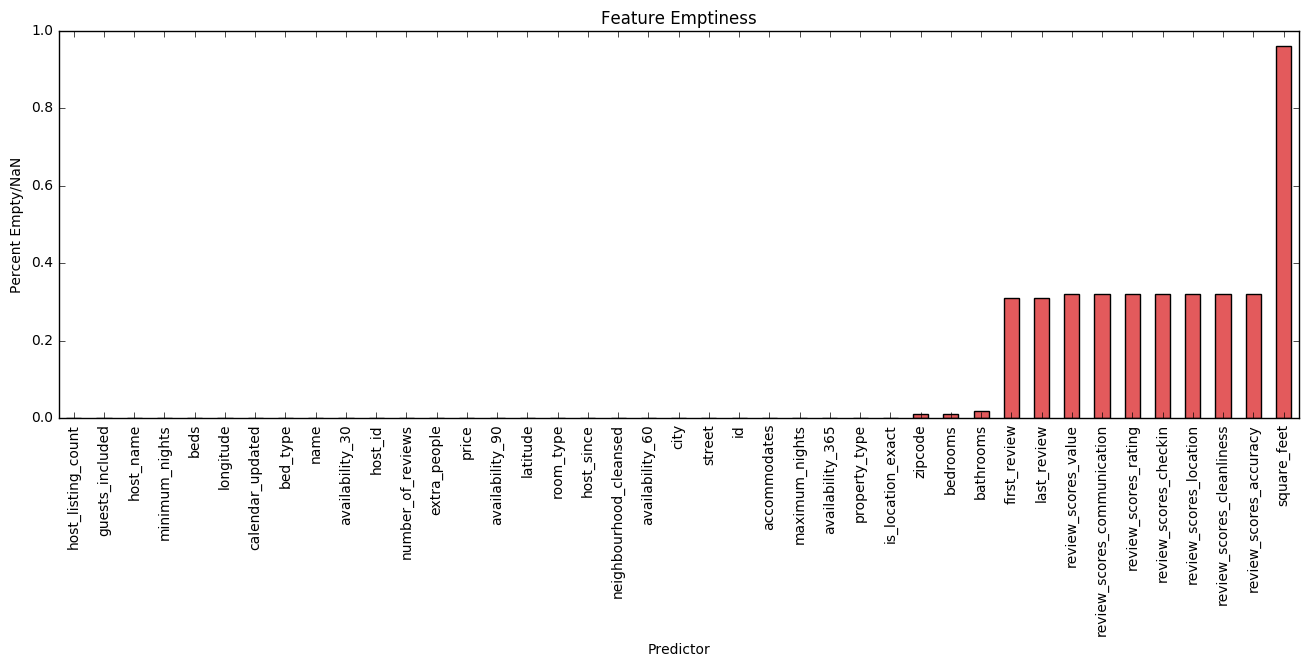

In [41]:
# Returns percent of missing data in column
def percent_empty(df):
    
    bools = df.isnull().tolist()
    percent_empty = float(bools.count(True)) / float(len(bools))
    
    return percent_empty

# Store emptiness for all features
emptiness = []

# Get emptiness for all features
for i in range(0, listings.shape[1]):
    emptiness.append(round(percent_empty(listings.iloc[:,i]), 2))
    
empty_dict = dict(zip(listings.columns.values.tolist(), emptiness))

# Plot emptiness graph
empty = pd.DataFrame.from_dict(empty_dict, orient = 'index').sort_values(by=0)
ax = empty.plot(kind = 'bar', color='#E35A5C', figsize = (16, 5))
ax.set_xlabel('Predictor')
ax.set_ylabel('Percent Empty/NaN')
ax.set_title('Feature Emptiness')
ax.legend_.remove()

plt.show()